## Exploration Exercises

Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.

- How many different cases are there, by department?
- Does the percentage of cases that are late vary by department?
- On average, how late are the late cases by department?
- What is the service type that is the most late? Just for Parks & Rec?
- For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.
- Does whether or not its a weekend matter for when a case is opened/closed?
- On average, how many cases are opened a day for the Customer Service department?
- Does the number of service requests for the solid waste department vary by day of the week?

In [20]:
import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

import wrangle as w

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [5]:
df = w.wrangle_311(spark)

[wrangle.py] reading case.csv


[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features


[wrangle.py] joining departments


In [8]:
df.show(1, False, True)

-RECORD 0----------------------------------------------------
 case_id              | 1014127332                           
 case_opened_date     | 2018-01-01 00:42:00                  
 case_closed_date     | 2018-01-01 12:29:00                  
 case_due_date        | 2020-09-26 00:42:00                  
 case_late            | false                                
 num_days_late        | -998.5087616000001                   
 case_closed          | true                                 
 service_request_type | Stray Animal                         
 SLA_days             | 999.0                                
 case_status          | Closed                               
 source_id            | svcCRMLS                             
 request_address      | 2315  EL PASO ST, San Antonio, 78207 
 council_district     | 005                                  
 num_weeks_late       | -142.6441088                         
 zipcode              | 78207                                
 case_ag

In [9]:
# How many different cases are there, by department?
df.groupby('department').count().show()

+--------------------+------+
|          department| count|
+--------------------+------+
|         Solid Waste|279270|
|Animal Care Services|116915|
|Trans & Cap Impro...| 96193|
|  Parks & Recreation| 19907|
|    Customer Service|  2849|
|        Metro Health|  5163|
|        City Council|    33|
|DSD/Code Enforcement|321374|
+--------------------+------+



Text(0.5, 0, 'Number of Cases')

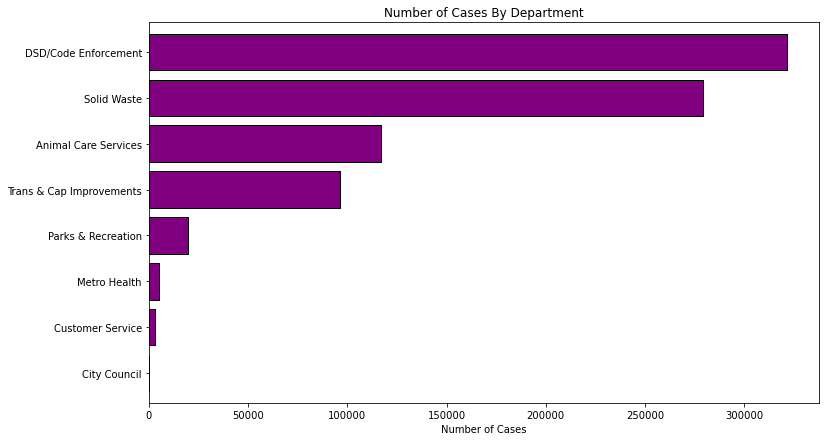

In [14]:
# First aggregate with spark
(
# group by    
    df.groupBy("department")
# aggregate by count    
    .count()
# then pass to pandas
    .toPandas()
# once its a dataframe, pass department as our index
    .set_index("department")["count"]
# sort our values for cleanliness of visualization
    .sort_values(ascending=True)
# pass our Series (department count values) to matplotlib
    .plot.barh(color = 'purple', width=.8, edgecolor="black", figsize=(12, 7))
)

plt.title("Number of Cases By Department")
plt.ylabel("")
plt.xlabel("Number of Cases")

In [15]:
# Does the percentage of cases that are late vary by department
df.groupby('department').pivot('case_late').count().fillna(0).show()

+--------------------+------+-----+
|          department| false| true|
+--------------------+------+-----+
|         Solid Waste|246325|32945|
|Animal Care Services| 93639|23276|
|Trans & Cap Impro...| 90782| 5411|
|    Customer Service|   839| 2010|
|  Parks & Recreation| 16110| 3797|
|        Metro Health|  4334|  829|
|        City Council|    33|    0|
|DSD/Code Enforcement|295139|26235|
+--------------------+------+-----+



In [17]:
# Finding all the late cases
late_cases = df.groupby('department').pivot('case_late').count().fillna(0)
# total counts
late_cases.withColumn('all', ( col('true') + col('false')) ).show()

+--------------------+------+-----+------+
|          department| false| true|   all|
+--------------------+------+-----+------+
|         Solid Waste|246325|32945|279270|
|Animal Care Services| 93639|23276|116915|
|Trans & Cap Impro...| 90782| 5411| 96193|
|    Customer Service|   839| 2010|  2849|
|  Parks & Recreation| 16110| 3797| 19907|
|        Metro Health|  4334|  829|  5163|
|        City Council|    33|    0|    33|
|DSD/Code Enforcement|295139|26235|321374|
+--------------------+------+-----+------+



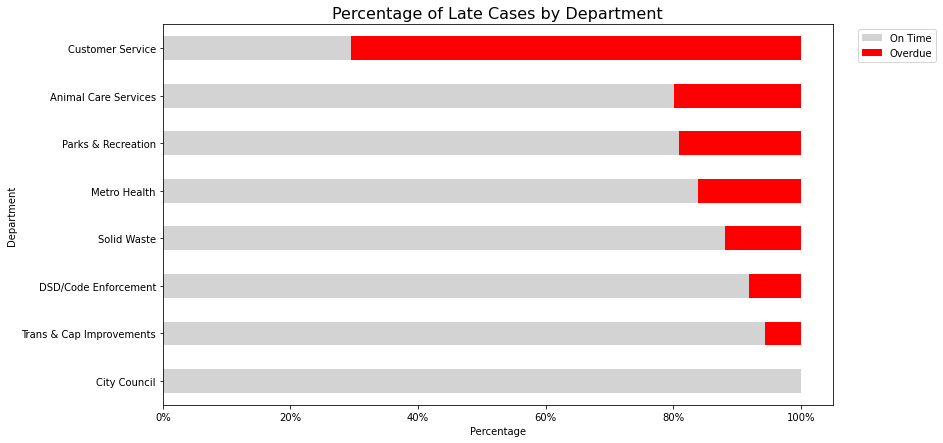

In [21]:
(
    # groupby Department
    df.groupby('department')
    
    # pivot on case late and count
    .pivot('case_late').count()
    .fillna(0)
    
    # create the all column
    .withColumn('all', col('true') + col('false') )
    
    # convert to pandas
    .toPandas()
    
    # set index to department for graphability
    .set_index('department')
    
    # apply function that calculates percentage for each row
    .apply(lambda row: row / row['all'], axis = 1)
    
    # drop the all column
    .drop(columns = 'all')
    
    # sort so highest percentage of late cases is at the top
    .sort_values(by = 'true')
    
    # plot as horizontal bar chart with custom colors
    .plot.barh(stacked = True, figsize = (12,7), color = ['lightgrey', 'red'])
)

plt.legend(labels = ['On Time', 'Overdue'], bbox_to_anchor = ((1.03, 1)))
plt.title('Percentage of Late Cases by Department', fontsize = 16)
plt.xlabel('Percentage')
plt.ylabel('Department')
# set x tick lables to percentage format
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter('{:.0%}'.format))

plt.show()

Moar liek customer disservice, amirite? City council has their cases on lock; fewest cases by a long shot, with 0% overall. 

In [22]:
# On average, how late are the late cases by department?
(
    df.filter(col('case_late') == 'true')
    .groupBy('department').agg(mean('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .show()
)

+--------------------+------------------+
|          department|     avg_days_late|
+--------------------+------------------+
|    Customer Service| 87.68385942150394|
|DSD/Code Enforcement| 49.38428705358908|
|Animal Care Services|23.458633245820124|
|  Parks & Recreation|22.348910457867518|
|Trans & Cap Impro...|10.603064680316946|
|         Solid Waste| 7.186821906120899|
|        Metro Health|6.5438133155476494|
+--------------------+------------------+



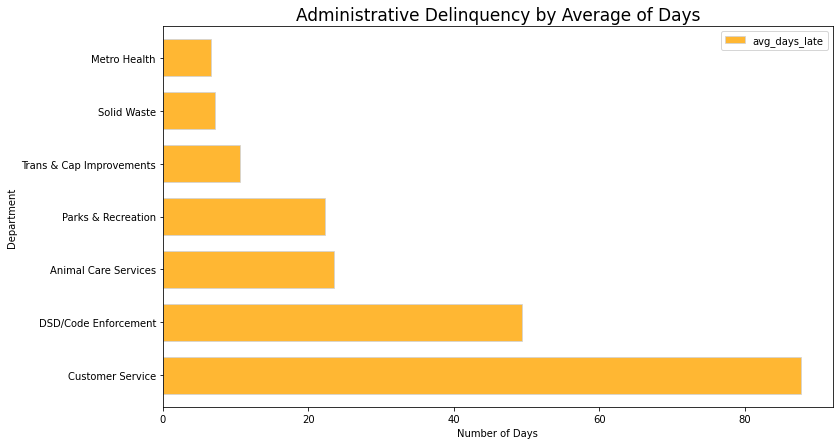

In [24]:
(
    df.filter(col('case_late') == 'true')
    .groupBy('department').agg(mean('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .toPandas()
    .set_index('department')
    .plot.barh(width = .7, ec = 'lightgrey', alpha = .8, color = 'orange', figsize = (12,7))
)
plt.title("Administrative Delinquency by Average of Days", fontsize = 17)
plt.xlabel("Number of Days")
plt.ylabel("Department")
plt.show()

In [25]:
# What is the service type that is the most late? Just for Parks & Rec?
# I can take the same approach, except grouping by the service type rather than dept
(
    df.filter(col('case_late') == 'true')
    .groupBy('service_request_type').agg(mean('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .show(10)
)

+--------------------+------------------+
|service_request_type|     avg_days_late|
+--------------------+------------------+
|Zoning: Recycle Yard|210.89201994318182|
|  Zoning: Junk Yards|200.20517608494276|
|Structure/Housing...|190.20707698509807|
|Donation Containe...|171.09115313942615|
|Storage of Used M...|163.96812829714287|
|Labeling for Used...|162.43032902285717|
|Record Keeping of...|153.99724039428568|
|Signage Requied f...|151.63868055333333|
|Traffic Signal Gr...|137.64583330000002|
|License Requied U...|128.79828704142858|
+--------------------+------------------+
only showing top 10 rows



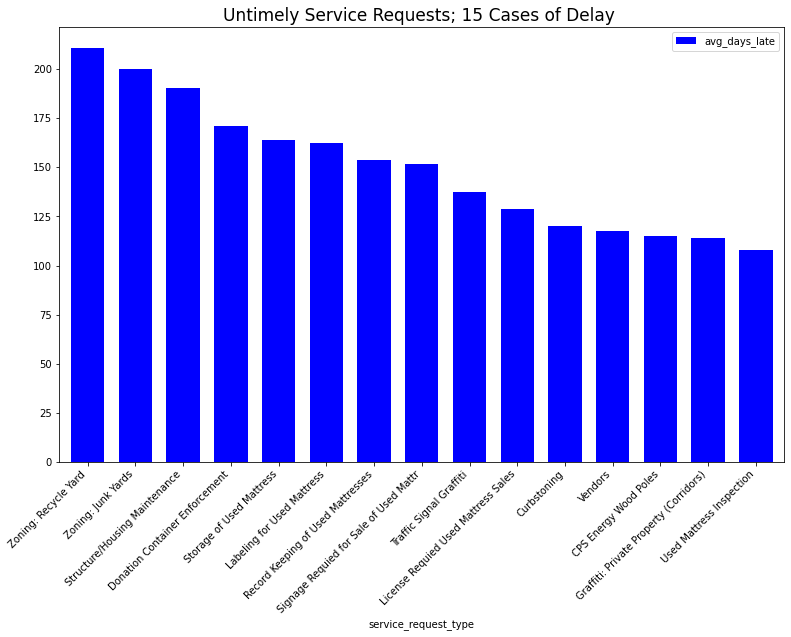

In [27]:
(
    df.filter(col('case_late') == 'true')
    .groupBy('service_request_type').agg(mean('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .toPandas()
    .set_index('service_request_type')
    .head(15)
    .plot.bar(figsize = (13,8), width = .7, color = 'blue')
)
plt.xticks(rotation = 45, ha = 'right')
plt.title('Untimely Service Requests; 15 Cases of Delay ', fontsize = 17)
plt.show()

In [28]:
# specify for parks and recreation
(
    df.filter(col('case_late') == 'true')
    .filter(col('department') == 'Parks & Recreation')
    .groupBy('service_request_type').agg(mean('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .show(10)
)

+--------------------+------------------+
|service_request_type|     avg_days_late|
+--------------------+------------------+
|Amenity Park Impr...|    76.87018194568|
|Major Park Improv...| 75.79450367282354|
|Reservation Assis...|       66.03116319|
|Park Building Mai...|59.367469802695666|
| Sportfield Lighting|51.480049793645534|
|          Electrical|42.951971658345116|
|        Tree Removal| 40.28404224560715|
|Landscape Mainten...| 38.86797941326316|
|     Heavy Equipment| 38.56625730831579|
|Miscellaneous Par...| 33.62472491253488|
+--------------------+------------------+
only showing top 10 rows



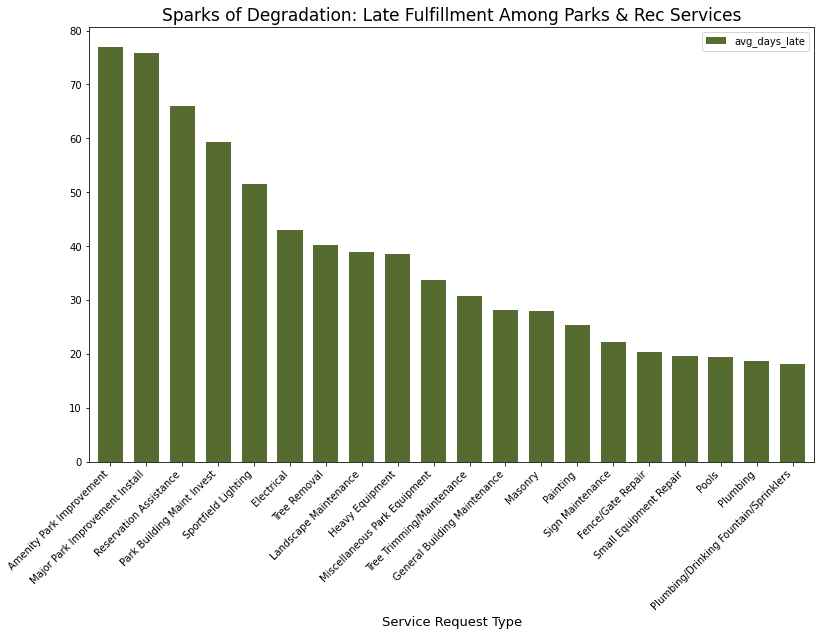

In [29]:
(
    df.filter(col('case_late') == 'true')
    .filter(col('department') == 'Parks & Recreation')
    .groupBy('service_request_type').agg(mean('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .toPandas()
    .set_index('service_request_type')
    .head(20)
    .plot.bar(figsize = (13,8), width = .7, color = 'darkolivegreen')
)
plt.xticks(rotation = 45, ha = 'right')
plt.xlabel('Service Request Type', fontsize = 13)
plt.title('Sparks of Degradation: Late Fulfillment Among Parks & Rec Services', fontsize = 17)
plt.show()

In [ ]:
# For the DSD/Code Enforcement department, what are the most common service request types?

In [ ]:
# Does whether or not its a weekend matter for when a case is opened/closed?

In [ ]:
# On average, how many cases are opened a day for the Customer Service department?

In [ ]:
# Does the number of service requests for the solid waste department vary by day of the week?